# Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
catalog = pd.read_csv('data/data_catalogue.csv')
data = pd.read_csv('data/data_arena_members.csv')

# Utils

In [114]:
def plot_hist2d(x,
                y,
                title,
                xlabel,
                ylabel,
                ax,
                bins=(50,50),
                cmap=plt.cm.BuPu):
    ax.hist2d(x, y, bins=bins, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def price_ditributions(catalog,
                       price='creds'):
    if not price in ['creds', 'gold']:
        raise ValueError('Can display only creds and gold distibutions!')
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,30))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Level {i + 1}')
        sns.distplot(catalog[catalog['item_level']==i+1]['item_price_credit' if price=='creds' else 'item_price_gold'].values,
                     kde=i!=0 and i!=9, bins=15, ax=ax)
    plt.show()
    
def get_regression_line(x,
                        y,
                        degree):
    params = np.polyfit(x, y, degree)
    poly = np.poly1d(params)
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = poly(x_grid)
    return x_grid, y_grid

def build_model(inputs):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[inputs]),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    loss = tf.keras.losses.MSE

    model.compile(loss=loss,
                  optimizer=optimizer)
    return model

def plot_history(models):
    k = len(models)
    
    fig, axs = plt.subplots(nrows=(k+1)//2, ncols=2, figsize=(16,30))
    
    for i, ax in enumerate(axs.flat):
        if i >= k:
            break
        
        history = models[i][1]
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
    
        ax.set_title(f'Model {i+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        
        ax.plot(hist['epoch'], hist['loss'], label='Train loss')
        ax.plot(hist['epoch'], hist['val_loss'], label='Val loss')
        
        ax.set_ylim([0,1])
        ax.legend()

    plt.show()
    
def get_mean_mse(models):
    total_loss = 0
    for model in models:
        total_loss += model[2]
    return total_loss / len(models)

def get_best_model(models):
    min_loss, ind = float('inf'), -1
    for i, model in enumerate(models):
        if model[2] < min_loss:
            min_loss = model[2]
            ind = i
    return models[ind][0]

# Catalog cleaning

In [4]:
removed_tanks = pd.DataFrame()

masks = [
    ('cleaning by crew_size: 2 <= crew_size <= 6', \
    (catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)),
    
    ('cleaning by 1 level: item_price_credit = item_price_gold = 0', \
    (catalog['item_level'] != 1) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0))),
    
    ('cleaning by price: item_price_credit > 100 or item_price_gold > 100', \
    (catalog['item_level'] == 1) | \
    (((catalog['item_price_credit'] > 100) & (catalog['item_price_gold'] == 0)) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] > 100)))),
    
    ('custom cleaning by price 2 level: 2000 < item_price_credit < 20000', \
    (catalog['item_level'] != 2) | (catalog['item_price_gold'] != 0) | \
    (catalog['item_price_credit'] > 2000) & (catalog['item_price_credit'] < 20000)),
    
    ('custom cleaning by price 5 level: item_price_credit < 500000', \
    (catalog['item_level'] != 5) | \
    (catalog['item_price_gold'] != 0) | (catalog['item_price_credit'] < 500000))
]

for mask in masks:
    N = len(catalog)
    
    removed_tanks = pd.concat([removed_tanks, catalog.loc[~mask[1]]])
    catalog = catalog.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(catalog)} rows.')
    
catalog.index = np.arange(len(catalog))
removed_tanks.index = np.arange(len(removed_tanks))

print(f'\nTotally removed {len(removed_tanks)} rows.')

[CLEANING BY CREW_SIZE: 2 <= CREW_SIZE <= 6]: removed 7 rows.
[CLEANING BY 1 LEVEL: ITEM_PRICE_CREDIT = ITEM_PRICE_GOLD = 0]: removed 9 rows.
[CLEANING BY PRICE: ITEM_PRICE_CREDIT > 100 OR ITEM_PRICE_GOLD > 100]: removed 98 rows.
[CUSTOM CLEANING BY PRICE 2 LEVEL: 2000 < ITEM_PRICE_CREDIT < 20000]: removed 20 rows.
[CUSTOM CLEANING BY PRICE 5 LEVEL: ITEM_PRICE_CREDIT < 500000]: removed 1 rows.

Totally removed 135 rows.


In [5]:
for feature in ['item_cd']:
    catalog[feature] = pd.Categorical(catalog[feature])

classEncoder = LabelEncoder()
catalog['item_class'] = classEncoder.fit_transform(catalog['item_class'])
catalog

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,1,4,356700,0,5,4
1,17,4,373000,0,5,5
2,33,2,0,1500,5,5
3,49,4,0,7500,8,4
4,81,4,0,0,1,5
...,...,...,...,...,...,...
748,64817,3,0,3500,6,5
749,65041,1,0,0,1,6
750,65073,2,0,12250,8,4
751,65297,2,0,12500,8,5


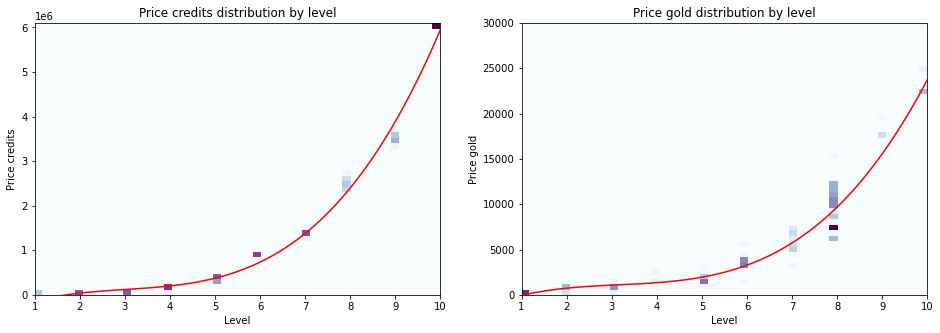

In [6]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

degree = 3
prices = creds_catalog[['item_level', 'item_price_credit']].values

plot_hist2d(x=creds_catalog['item_level'],
            y=creds_catalog['item_price_credit'],
            title='Price credits distribution by level',
            xlabel='Level',
            ylabel='Price credits',
            ax=axs[0])
axs[0].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

degree = 3
prices = gold_catalog[['item_level', 'item_price_gold']].values

plot_hist2d(x=gold_catalog['item_level'],
            y=gold_catalog['item_price_gold'],
            title='Price gold distribution by level',
            xlabel='Level',
            ylabel='Price gold',
            ax=axs[1])
axs[1].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

plt.show()

In [ ]:
price_ditributions(creds_catalog, price='creds')

In [ ]:
price_ditributions(gold_catalog, price='gold')

In [ ]:
print(f'Catalog shape: {catalog.shape}\n')
print(f'Duplicates num: {catalog.duplicated().sum()}\n')
print(f'NaN num:\n{catalog.isnull().sum()}')

In [ ]:
catalog.info()

# Removed tanks

In [7]:
s1 = set(removed_tanks['item_cd'])
s2 = set(data['vehicle_type_cd'])

removed_ids = s1.intersection(s2)

print(removed_ids)

{6225, 13889, 9297, 65281}


# Catalog visualizing

In [ ]:
sns.countplot(classEncoder.inverse_transform(catalog['item_class']));

In [ ]:
sns.countplot(catalog['item_level']);

In [ ]:
sns.countplot(catalog['crew_size']);

# Arenas data cleaning

In [8]:
mask = ~data['vehicle_type_cd'].isin(removed_ids)

removed_data = data.loc[~mask]
data = data.loc[mask]

data.index = np.arange(len(data))
removed_data.index = np.arange(len(removed_data))

In [9]:
for feature in ['clan_db_id', 'is_prebattle_creator', 'vehicle_type_cd']:
    data[feature] = pd.Categorical(data[feature])

data['dt'] = pd.to_datetime(data['dt'])

In [ ]:
print(f'Catalog shape: {data.shape}\n')
print(f'Duplicates num: {data.duplicated().sum()}\n')
print(f'NaN num:\n{data.isnull().sum()}')

In [ ]:
data.info()

# Creating new features

In [10]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0

def is_warrior(kills):
    return kills >= 6

def is_steel_wall(remained_hp, shots_received, damage_blocked_by_armor, damage_received):
    return remained_hp > 0 and shots_received >= 11 and damage_blocked_by_armor + damage_received >= 1000

def calculate_winner_team_id(df):
    def calc_winner(row):
        winner = 0
        if row['num_tanks_pos_1'] != 0 and row['num_tanks_pos_2'] == 0:
            winner = 1
        elif row['num_tanks_pos_2'] != 0 and row['num_tanks_pos_1'] == 0:
            winner = 2
        else:
            if row['mean_xp_1'] / row['mean_xp_2'] > 1.8:
                winner = 1
            elif row['mean_xp_2'] / row['mean_xp_1'] > 1.8:
                winner = 2
            else:
                winner = 0     
        return winner

    print('[FILTERING DATA...]', end='  ')
    warriors = df[df.groupby('arena_id')['account_db_id'].transform('count') == 30]
    warriors.index = np.arange(len(warriors))
    print(f'[FILTERED]: removed {len(df) - len(warriors)} rows!')
    
    print('[GROUPING BATTLES AND TEAMS...]', end='  ')
    battles = warriors.groupby(['arena_id', 'team_id'])
    print(f'[GROUPED BATTLES AND TEAMS]: There are {sum(battles["account_db_id"].count() != 15)} not full teams!')

    print('[CALCULATING STATS...]', end='  ')
    info_df = pd.DataFrame(index = [ind[0] for ind in battles.count().index][::2])
    info_df['num_tanks_pos_1'] = battles['is_alive'].sum().iloc[::2].values
    info_df['num_tanks_pos_2'] = battles['is_alive'].sum().iloc[1::2].values
    info_df['mean_xp_1'] = battles['original_xp'].mean().iloc[::2].values
    info_df['mean_xp_2'] = battles['original_xp'].mean().iloc[1::2].values
    print(f'[CALCULATED STATS]: There are {len(battles) // 2} restored battles!')
    
    print('[CALCULATING WINNERS...]', end='  ')
    info_df['winner_team_id'] = info_df.apply(calc_winner, axis=1)
    print('[CALCULATED WINNERS]')
    
    print('[JOINING...]', end='  ')
    info_df.reset_index(inplace=True)
    df = df.merge(info_df[['index', 'winner_team_id']], how='left', left_on='arena_id', right_on='index')
    df.drop(columns=['index'], inplace=True, axis=1)
    print('[JOINED]')
    
    return df

normalize_feature = np.vectorize(normalize_feature)
is_warrior = np.vectorize(is_warrior)
is_steel_wall = np.vectorize(is_steel_wall)

In [11]:
# total damage
data['total_damage_dealt'] = data['damage_dealt'] + data['damage_assisted_radio'] + \
                             data['damage_assisted_stun'] + data['damage_assisted_track']

# rates
data['hit_rate'] = normalize_feature(data['hits'], data['shots'])
data['pierced_rate'] = normalize_feature(data['pierced'], data['hits'])
data['he_hit_rate'] = normalize_feature(data['he_hits'], data['hits'])

# achievements
data['is_warrior'] = is_warrior(data['kills_made'])
data['is_steel_wall'] = is_steel_wall(data['remained_hp'], data['shots_received'], data['damage_blocked_by_armor'], data['damage_received'])

# fetures per minute
data['life_time_min'] = data['life_time_sec'] / 60

data['damage_dealt_per_minute'] = normalize_feature(data['damage_dealt'], data['life_time_min'])
data['damage_assisted_radio_per_minute'] = normalize_feature(data['damage_assisted_radio'], data['life_time_min'])
data['damage_assisted_stun_per_minute'] = normalize_feature(data['damage_assisted_stun'], data['life_time_min'])
data['damage_assisted_track_per_minute'] = normalize_feature(data['damage_assisted_track'], data['life_time_min'])
data['total_damage_dealt_per_minute'] = normalize_feature(data['total_damage_dealt'], data['life_time_min'])
data['damage_received_per_minute'] = normalize_feature(data['damage_received'], data['life_time_min'])

data['shots_per_minute'] = normalize_feature(data['shots'], data['life_time_min'])
data['hits_per_minute'] = normalize_feature(data['hits'], data['life_time_min'])
data['he_hits_per_minute'] = normalize_feature(data['he_hits'], data['life_time_min'])
data['pierced_per_minute'] = normalize_feature(data['pierced'], data['life_time_min'])
data['pierced_received_per_minute'] = normalize_feature(data['pierced_received'], data['life_time_min'])
data['no_damage_shots_received_per_minute'] = normalize_feature(data['no_damage_shots_received'], data['life_time_min'])
data['shots_received_per_minute'] = normalize_feature(data['shots_received'], data['life_time_min'])

data['mileage_meter_per_minute'] = normalize_feature(data['mileage_meter'], data['life_time_min'])
data['kills_made_per_minute'] = normalize_feature(data['kills_made'], data['life_time_min'])
data['damaged_per_minute'] = normalize_feature(data['damaged'], data['life_time_min'])
data['spotted_per_minute'] = normalize_feature(data['spotted'], data['life_time_min'])

# win_rate
data['is_alive'] = data['remained_hp'] > 0
data = calculate_winner_team_id(data)
data['is_winner'] = data['team_id'] == data['winner_team_id']

[FILTERING DATA...]  [FILTERED]: removed 38588 rows!
[GROUPING BATTLES AND TEAMS...]  [GROUPED BATTLES AND TEAMS]: There are 0 not full teams!
[CALCULATING STATS...]  [CALCULATED STATS]: There are 45479 restored battles!
[CALCULATING WINNERS...]  [CALCULATED WINNERS]
[JOINING...]  [JOINED]


In [12]:
players_df = data.groupby('account_db_id').agg({'life_time_min' : 'mean',
                                                'kills_made_per_minute' : 'mean',
                                                'remained_hp' : 'mean',
                                                'original_credits' : 'mean',
                                                'original_xp' : 'mean',
                                                'daily_xp_factor' : 'mean',
                                                'total_damage_dealt_per_minute' : 'mean',
                                                'shots_per_minute' : 'mean',
                                                'hits_per_minute' : 'mean',
                                                'pierced_per_minute' : 'mean',
                                                'damage_received_per_minute' : 'mean',
                                                'shots_received_per_minute' : 'mean',
                                                'damaged_per_minute' : 'mean',
                                                'pierced_rate' : 'mean',
                                                'is_winner' : lambda g: sum(g) / len(g)})

players_df

,life_time_min,kills_made_per_minute,remained_hp,original_credits,original_xp,daily_xp_factor,total_damage_dealt_per_minute,shots_per_minute,hits_per_minute,pierced_per_minute,damage_received_per_minute,shots_received_per_minute,damaged_per_minute,pierced_rate,is_winner
account_db_id,,,,,,,,,,,,,,,
c2111224a,5.633333,0.000000,-2.000000,10023.000000,828.000000,20.000000,73.313609,1.242604,0.177515,0.177515,69.230769,0.177515,0.532544,1.000000,0.00
c211122N4,3.716667,0.000000,0.000000,30101.000000,797.000000,10.000000,367.533632,1.076233,1.076233,0.538117,403.587444,2.152466,0.538117,0.500000,0.00
c21112TT1,2.604167,0.068182,0.000000,16040.500000,424.750000,12.500000,409.979539,2.424638,1.888018,1.751654,638.018102,2.822868,0.538430,0.700000,0.25
c21112aa2,4.675000,0.082873,550.000000,20036.000000,1943.000000,30.000000,283.773564,0.896610,0.414365,0.331492,135.678392,0.603015,0.331492,0.400000,1.00
c21112yNT,4.116667,0.000000,0.000000,37012.000000,755.000000,10.000000,376.518219,1.700405,1.214575,0.728745,279.352227,0.728745,0.971660,0.600000,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyyT74,4.900000,0.057062,241.666667,22431.333333,1019.333333,16.666667,226.112734,1.249104,0.920892,0.595962,246.841646,0.996444,0.549782,0.688889,0.50
cyyyyya7c,6.379167,0.196946,170.625000,81740.375000,1894.250000,13.750000,483.947612,2.335348,1.975324,1.359835,237.208972,1.029219,0.736122,0.718518,0.50
cyyyyyd1a,2.266667,0.000000,0.000000,8617.000000,221.000000,10.000000,327.794118,0.882353,0.441176,0.441176,661.764706,2.205882,0.441176,1.000000,0.00


In [13]:
players_no_nan_df = players_df.dropna()

X = np.array(players_no_nan_df[['original_xp', 'daily_xp_factor', 'remained_hp', 'original_credits',
                                'kills_made_per_minute', 'total_damage_dealt_per_minute', 'life_time_min',
                                'shots_per_minute', 'hits_per_minute', 'pierced_per_minute',
                                'damage_received_per_minute', 'shots_received_per_minute', 'damaged_per_minute',
                                'pierced_rate']])
Y = np.array(players_no_nan_df['is_winner'])

reg = LinearRegression().fit(X, Y)
reg.score(X, Y)

0.44506759333931145

In [14]:
players_df['is_winner_ML'] = reg.predict(np.array(players_df[['original_xp', 'daily_xp_factor', 'remained_hp',
                                                              'original_credits', 'kills_made_per_minute',
                                                              'total_damage_dealt_per_minute', 'life_time_min',
                                                              'shots_per_minute', 'hits_per_minute', 'pierced_per_minute',
                                                              'damage_received_per_minute', 'shots_received_per_minute',
                                                              'damaged_per_minute', 'pierced_rate']]))
players_df['is_winner_ML'][players_df['is_winner_ML'] > 1] = 1
players_df['is_winner_ML'][players_df['is_winner_ML'] < 0] = 0

players_df

,life_time_min,kills_made_per_minute,remained_hp,original_credits,original_xp,daily_xp_factor,total_damage_dealt_per_minute,shots_per_minute,hits_per_minute,pierced_per_minute,damage_received_per_minute,shots_received_per_minute,damaged_per_minute,pierced_rate,is_winner,is_winner_ML
account_db_id,,,,,,,,,,,,,,,,
c2111224a,5.633333,0.000000,-2.000000,10023.000000,828.000000,20.000000,73.313609,1.242604,0.177515,0.177515,69.230769,0.177515,0.532544,1.000000,0.00,0.490434
c211122N4,3.716667,0.000000,0.000000,30101.000000,797.000000,10.000000,367.533632,1.076233,1.076233,0.538117,403.587444,2.152466,0.538117,0.500000,0.00,0.315224
c21112TT1,2.604167,0.068182,0.000000,16040.500000,424.750000,12.500000,409.979539,2.424638,1.888018,1.751654,638.018102,2.822868,0.538430,0.700000,0.25,0.257052
c21112aa2,4.675000,0.082873,550.000000,20036.000000,1943.000000,30.000000,283.773564,0.896610,0.414365,0.331492,135.678392,0.603015,0.331492,0.400000,1.00,0.990667
c21112yNT,4.116667,0.000000,0.000000,37012.000000,755.000000,10.000000,376.518219,1.700405,1.214575,0.728745,279.352227,0.728745,0.971660,0.600000,1.00,0.325541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyyT74,4.900000,0.057062,241.666667,22431.333333,1019.333333,16.666667,226.112734,1.249104,0.920892,0.595962,246.841646,0.996444,0.549782,0.688889,0.50,0.530091
cyyyyya7c,6.379167,0.196946,170.625000,81740.375000,1894.250000,13.750000,483.947612,2.335348,1.975324,1.359835,237.208972,1.029219,0.736122,0.718518,0.50,0.596192
cyyyyyd1a,2.266667,0.000000,0.000000,8617.000000,221.000000,10.000000,327.794118,0.882353,0.441176,0.441176,661.764706,2.205882,0.441176,1.000000,0.00,0.251128


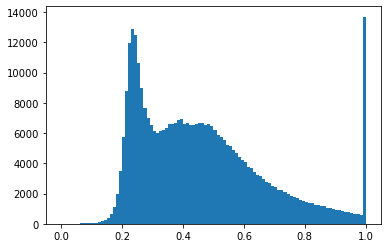

0.4646440136518806

In [15]:
plt.hist(players_df['is_winner_ML'], bins=100)
plt.show()

players_df['is_winner_ML'].mean()

In [16]:
data['is_plat'] = data['prebattle_id'] != 0

players_df['plat_rate'] = data.groupby('account_db_id').agg({'is_plat' : lambda g: sum(g) / len(g)})
players_df

,life_time_min,kills_made_per_minute,remained_hp,original_credits,original_xp,daily_xp_factor,total_damage_dealt_per_minute,shots_per_minute,hits_per_minute,pierced_per_minute,damage_received_per_minute,shots_received_per_minute,damaged_per_minute,pierced_rate,is_winner,is_winner_ML,plat_rate
account_db_id,,,,,,,,,,,,,,,,,
c2111224a,5.633333,0.000000,-2.000000,10023.000000,828.000000,20.000000,73.313609,1.242604,0.177515,0.177515,69.230769,0.177515,0.532544,1.000000,0.00,0.490434,0.00
c211122N4,3.716667,0.000000,0.000000,30101.000000,797.000000,10.000000,367.533632,1.076233,1.076233,0.538117,403.587444,2.152466,0.538117,0.500000,0.00,0.315224,1.00
c21112TT1,2.604167,0.068182,0.000000,16040.500000,424.750000,12.500000,409.979539,2.424638,1.888018,1.751654,638.018102,2.822868,0.538430,0.700000,0.25,0.257052,0.25
c21112aa2,4.675000,0.082873,550.000000,20036.000000,1943.000000,30.000000,283.773564,0.896610,0.414365,0.331492,135.678392,0.603015,0.331492,0.400000,1.00,0.990667,0.50
c21112yNT,4.116667,0.000000,0.000000,37012.000000,755.000000,10.000000,376.518219,1.700405,1.214575,0.728745,279.352227,0.728745,0.971660,0.600000,1.00,0.325541,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyyT74,4.900000,0.057062,241.666667,22431.333333,1019.333333,16.666667,226.112734,1.249104,0.920892,0.595962,246.841646,0.996444,0.549782,0.688889,0.50,0.530091,0.00
cyyyyya7c,6.379167,0.196946,170.625000,81740.375000,1894.250000,13.750000,483.947612,2.335348,1.975324,1.359835,237.208972,1.029219,0.736122,0.718518,0.50,0.596192,0.50
cyyyyyd1a,2.266667,0.000000,0.000000,8617.000000,221.000000,10.000000,327.794118,0.882353,0.441176,0.441176,661.764706,2.205882,0.441176,1.000000,0.00,0.251128,0.00


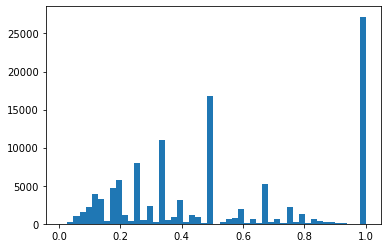

In [18]:
plt.hist(players_df[players_df['plat_rate'] != 0]['plat_rate'], bins=50)
plt.show()

In [19]:
players_df['warriors'] = data.groupby('account_db_id')['is_warrior'].sum()
players_df['steel_wall'] = data.groupby('account_db_id')['is_steel_wall'].sum()

In [20]:
train_players_df = players_df.copy(deep=True)
train_players_df.drop(columns=['is_winner'], inplace=True, axis=1)

playersScaler = StandardScaler()
normed_train_players_df = pd.DataFrame(playersScaler.fit_transform(train_players_df), columns=train_players_df.columns)

pcaPlayers = PCA(n_components=0.95)
pca_components = pcaPlayers.fit_transform(normed_train_players_df)

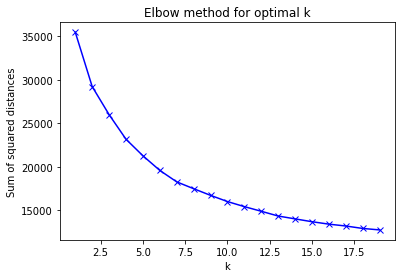

In [21]:
inertias = []
K = range(1, 20)

for k in K:
    model = KMeans(n_clusters=k)
    model = model.fit(pca_components[:2000])
    inertias.append(model.inertia_)
    
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal k')
plt.show()

In [22]:
best_model = KMeans(n_clusters=7)
best_model.fit(pca_components)
preds = best_model.predict(pca_components)

players_df['segment'] = preds

# Joining dataframes

In [23]:
players_df = players_df.reset_index()
players_df = players_df[['account_db_id', 'is_winner_ML', 'plat_rate', 'warriors', 'steel_wall', 'segment']]
players_df

,account_db_id,is_winner_ML,plat_rate,warriors,steel_wall,segment
0,c2111224a,0.490434,0.00,0.0,0.0,3
1,c211122N4,0.315224,1.00,0.0,0.0,5
2,c21112TT1,0.257052,0.25,0.0,0.0,6
3,c21112aa2,0.990667,0.50,0.0,0.0,4
4,c21112yNT,0.325541,0.00,0.0,0.0,5
...,...,...,...,...,...,...
367680,cyyyyyT74,0.530091,0.00,0.0,0.0,3
367681,cyyyyya7c,0.596192,0.50,0.0,0.0,2
367682,cyyyyyd1a,0.251128,0.00,0.0,0.0,1
367683,cyyyyyd1c,0.687624,0.00,0.0,0.0,2


In [28]:
data.drop(columns=['dt', 'arena_id', 'shots', 'team_id', 'clan_db_id', 'prebattle_id', 'is_prebattle_creator',
                   'life_time_sec', 'damage_dealt', 'damage_assisted_radio', 'damage_assisted_stun',
                   'damage_assisted_track', 'hits', 'he_hits', 'pierced', 'damage_received', 'shots_received',
                   'no_damage_shots_received', 'pierced_received', 'spotted', 'damaged',
                   'kills_made', 'mileage_meter', 'battle_num', 'damage_blocked_by_armor', 
                   'total_damage_dealt', 'is_alive', 'winner_team_id', 'is_winner', 'is_plat'], inplace=True, axis=1)

data

,account_db_id,vehicle_type_cd,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,booster_bonus_credits,booster_bonus_xp,hit_rate,...,hits_per_minute,he_hits_per_minute,pierced_per_minute,pierced_received_per_minute,no_damage_shots_received_per_minute,shots_received_per_minute,mileage_meter_per_minute,kills_made_per_minute,damaged_per_minute,spotted_per_minute
0,c42c4aydT,2849,-3,27279,1084,15,20,0,0,0.666667,...,0.909091,0.0,0.909091,2.272727,0.454545,2.727273,208.636364,0.000000,0.909091,0.454545
1,c2TaaayN4,63553,0,6282,68,15,10,0,0,0.500000,...,0.923077,0.0,0.307692,1.538462,0.000000,1.538462,217.846154,0.000000,0.307692,0.307692
2,cyyd47dc4,17665,0,36102,3560,15,20,0,1130,0.909091,...,2.678571,0.0,1.875000,1.339286,0.000000,1.339286,175.714286,0.535714,1.071429,0.000000
3,c2cdc441y,11537,387,16317,1678,15,20,0,0,0.625000,...,0.787402,0.0,0.629921,0.314961,0.157480,0.472441,301.102362,0.629921,0.629921,0.157480
4,cdT7cTT21,7937,0,11620,232,15,10,0,0,0.600000,...,0.909091,0.0,0.606061,1.515152,0.000000,1.515152,153.636364,0.303030,0.606061,0.303030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402953,cac4aa12N,1921,425,77063,2532,15,20,0,0,0.666667,...,0.989011,0.0,0.989011,0.329670,0.000000,0.329670,356.208791,0.000000,0.329670,0.000000
1402954,cdTcc72Nc,913,0,34367,294,15,10,0,0,0.833333,...,0.964630,0.0,0.964630,1.157556,0.578778,1.736334,217.234727,0.192926,0.578778,0.192926
1402955,cd42c2TTT,50193,0,10361,90,15,10,0,0,0.500000,...,0.344828,0.0,0.344828,1.724138,0.000000,1.724138,167.241379,0.000000,0.344828,0.344828
1402956,cd4a7Tc72,51361,0,48382,740,15,10,0,0,0.857143,...,2.647059,0.0,1.764706,2.647059,0.000000,2.647059,335.294118,0.000000,1.764706,0.882353


In [29]:
joined_data = data.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')
joined_data.drop(['item_cd'], axis=1, inplace=True)
joined_data

,account_db_id,vehicle_type_cd,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,booster_bonus_credits,booster_bonus_xp,hit_rate,...,shots_received_per_minute,mileage_meter_per_minute,kills_made_per_minute,damaged_per_minute,spotted_per_minute,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,c42c4aydT,2849,-3,27279,1084,15,20,0,0,0.666667,...,2.727273,208.636364,0.000000,0.909091,0.454545,2,0,12000,8,6
1,c2TaaayN4,63553,0,6282,68,15,10,0,0,0.500000,...,1.538462,217.846154,0.000000,0.307692,0.307692,4,0,7450,8,4
2,cyyd47dc4,17665,0,36102,3560,15,20,0,1130,0.909091,...,1.339286,175.714286,0.535714,1.071429,0.000000,4,3450000,0,9,4
3,c2cdc441y,11537,387,16317,1678,15,20,0,0,0.625000,...,0.472441,301.102362,0.629921,0.629921,0.157480,0,2570000,0,8,5
4,cdT7cTT21,7937,0,11620,232,15,10,0,0,0.600000,...,1.515152,153.636364,0.303030,0.606061,0.303030,4,3450000,0,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402953,cac4aa12N,1921,425,77063,2532,15,20,0,0,0.666667,...,0.329670,356.208791,0.000000,0.329670,0.000000,2,2540000,0,8,3
1402954,cdTcc72Nc,913,0,34367,294,15,10,0,0,0.833333,...,1.736334,217.234727,0.192926,0.578778,0.192926,2,0,10700,8,4
1402955,cd42c2TTT,50193,0,10361,90,15,10,0,0,0.500000,...,1.724138,167.241379,0.000000,0.344828,0.344828,0,0,10900,8,4
1402956,cd4a7Tc72,51361,0,48382,740,15,10,0,0,0.857143,...,2.647059,335.294118,0.000000,1.764706,0.882353,4,0,11000,8,4


In [30]:
joined_data = joined_data.merge(players_df, how='left', left_on='account_db_id', right_on='account_db_id')
joined_data

,account_db_id,vehicle_type_cd,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,booster_bonus_credits,booster_bonus_xp,hit_rate,...,item_class,item_price_credit,item_price_gold,item_level,crew_size,is_winner_ML,plat_rate,warriors,steel_wall,segment
0,c42c4aydT,2849,-3,27279,1084,15,20,0,0,0.666667,...,2,0,12000,8,6,0.309997,0.000000,0.0,0.0,1
1,c2TaaayN4,63553,0,6282,68,15,10,0,0,0.500000,...,4,0,7450,8,4,0.306829,0.000000,0.0,0.0,5
2,cyyd47dc4,17665,0,36102,3560,15,20,0,1130,0.909091,...,4,3450000,0,9,4,0.770443,0.666667,1.0,0.0,0
3,c2cdc441y,11537,387,16317,1678,15,20,0,0,0.625000,...,0,2570000,0,8,5,0.500316,0.000000,0.0,0.0,5
4,cdT7cTT21,7937,0,11620,232,15,10,0,0,0.600000,...,4,3450000,0,9,4,0.622412,0.000000,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402953,cac4aa12N,1921,425,77063,2532,15,20,0,0,0.666667,...,2,2540000,0,8,3,0.445902,1.000000,0.0,1.0,2
1402954,cdTcc72Nc,913,0,34367,294,15,10,0,0,0.833333,...,2,0,10700,8,4,0.237601,0.333333,0.0,0.0,5
1402955,cd42c2TTT,50193,0,10361,90,15,10,0,0,0.500000,...,0,0,10900,8,4,0.557135,0.500000,0.0,0.0,3
1402956,cd4a7Tc72,51361,0,48382,740,15,10,0,0,0.857143,...,4,0,11000,8,4,0.324323,0.450000,0.0,0.0,5


# Correlations

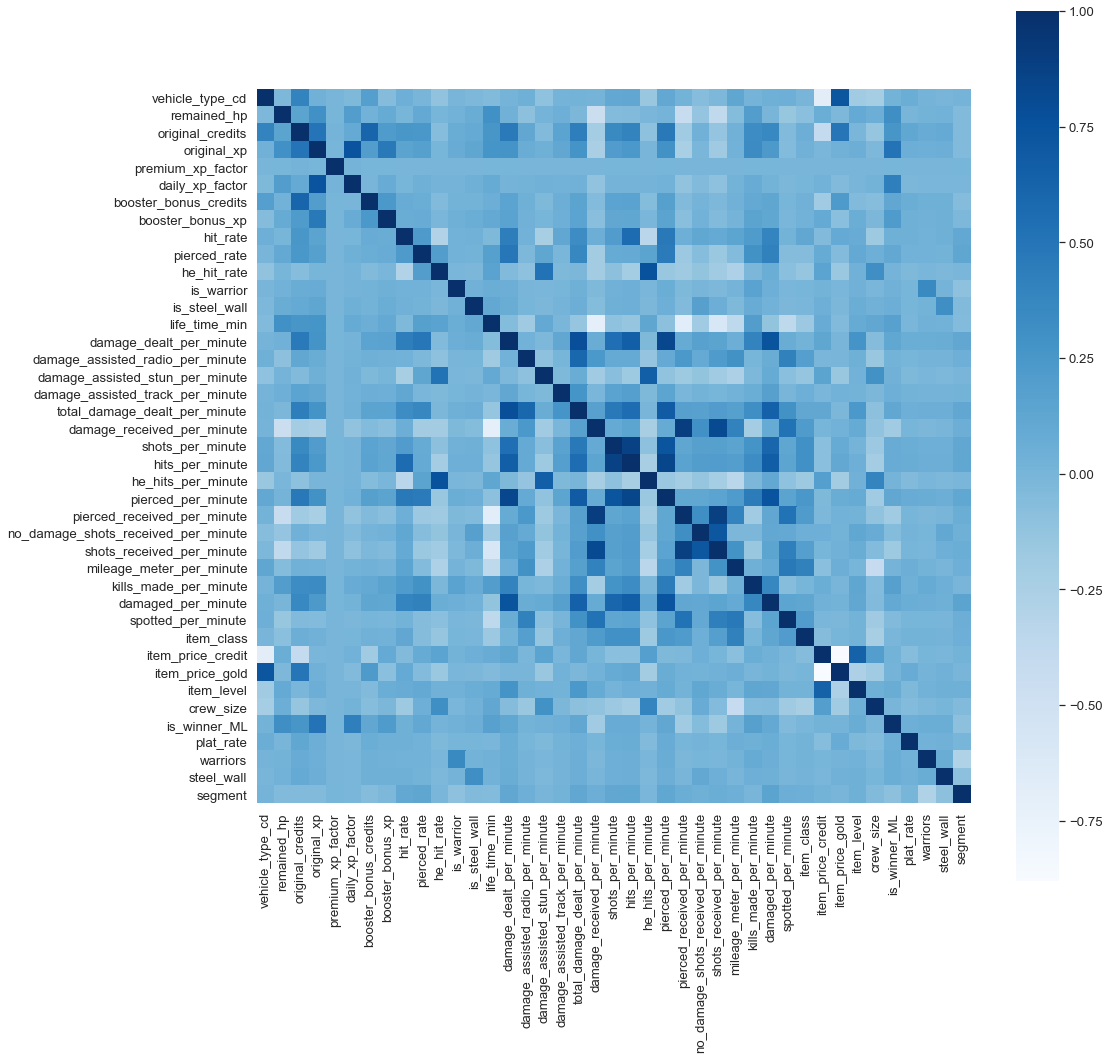

item_price_credit                     -0.879595
item_level                            -0.257673
he_hits_per_minute                    -0.197115
crew_size                             -0.190591
he_hit_rate                           -0.155768
damage_assisted_stun_per_minute       -0.147580
booster_bonus_xp                      -0.081813
pierced_rate                          -0.045380
life_time_min                         -0.039822
daily_xp_factor                       -0.037196
remained_hp                           -0.023619
total_damage_dealt_per_minute         -0.018295
is_steel_wall                         -0.017800
spotted_per_minute                    -0.015759
is_warrior                            -0.007435
kills_made_per_minute                 -0.003752
damage_assisted_radio_per_minute      -0.002405
segment                               -0.001987
premium_xp_factor                     -0.000887
damage_dealt_per_minute                0.000718
item_class                             0

In [36]:
sns.set(font_scale=1.2)

corr = joined_data.corr()

plt.figure(figsize=(16,16))
sns.heatmap(corr, square=True, cmap='Blues')

plt.show()

corr['item_price_gold'].sort_values()

# Regression model

In [89]:
res_data = joined_data.groupby('vehicle_type_cd').mean().reset_index()
tank_params = res_data[res_data['vehicle_type_cd'] == 9217]
tank_params.drop(columns=['item_price_credit', 'item_price_gold'], inplace=True, axis=1)
res_data = res_data[res_data['vehicle_type_cd'] != 9217]

features = list(res_data.columns)
features.remove('item_price_credit'); features.remove('item_price_gold')
target_credit = ['item_price_credit']
target_gold = ['item_price_gold']

credit_dataset = res_data[res_data['item_price_credit'] != 0][features + target_credit]
gold_dataset = res_data[res_data['item_price_gold'] != 0][features + target_gold]

credit_dataset.index = np.arange(len(credit_dataset))
gold_dataset.index = np.arange(len(gold_dataset))

gold_dataset

In [61]:
credit_scaler = StandardScaler()
gold_scaler = StandardScaler()

normed_credit_dataset = pd.DataFrame(credit_scaler.fit_transform(credit_dataset), columns=[features + target_credit])
normed_gold_dataset = pd.DataFrame(gold_scaler.fit_transform(gold_dataset), columns=[features + target_gold])

normed_gold_dataset

,vehicle_type_cd,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,booster_bonus_credits,booster_bonus_xp,hit_rate,pierced_rate,...,spotted_per_minute,item_class,item_level,crew_size,is_winner_ML,plat_rate,warriors,steel_wall,segment,item_price_gold
0,-3.219341,-0.267621,1.141226,0.547770,0.152377,-0.385065,1.610841,0.431023,0.744478,-0.014908,...,0.248936,0.992210,0.387992,-0.552158,0.192375,-0.130730,0.192740,-0.071124,0.131743,-0.275670
1,-3.213397,-0.787676,-1.496622,-0.854265,0.152377,-0.374847,-0.970271,1.102206,-1.257492,-1.415762,...,-0.174060,0.992210,-1.588919,0.760751,-0.433579,-0.638478,-0.806771,-0.646269,0.708874,-1.098348
2,-3.203489,-0.727795,-0.348981,0.247570,0.152377,-0.254572,-0.173852,0.341047,-0.573945,-0.119551,...,1.971869,0.298312,-0.600463,-0.552158,0.043956,-0.317838,0.268797,-0.063424,0.253435,-0.852613
3,-3.171786,-0.038340,0.614860,0.171613,-0.312364,-0.049359,0.929419,0.056329,0.835450,-0.559086,...,-0.036466,-0.395587,0.387992,-0.552158,-0.136548,-0.717349,0.110183,0.370538,0.759380,0.739321
4,-3.165841,0.357779,1.036430,0.753712,0.152377,-0.002512,1.028066,0.656490,0.837553,-0.289704,...,-0.411850,-0.395587,0.387992,-0.552158,0.431279,-0.174972,-0.172378,0.095411,0.374383,0.408113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.757490,-0.432176,-0.031023,-0.226705,0.152377,0.283969,0.030161,-0.075622,-0.295588,-0.076181,...,0.043798,0.992210,0.387992,-0.552158,-0.231526,-0.383602,-0.430205,-0.457409,0.415335,-0.019251
103,0.775324,0.086519,0.590830,0.318496,0.152377,-0.184141,0.542041,0.156850,0.608064,-1.120690,...,-0.182036,-0.395587,0.387992,-0.552158,-0.124811,-0.353535,0.118645,0.590253,0.105903,0.365377
104,0.788203,-0.044085,-0.910507,-0.039401,0.152377,-0.467459,0.092810,0.007252,-1.738946,2.479550,...,-0.630160,-0.395587,-1.588919,2.073659,0.136885,1.232727,0.258041,0.553560,-1.107577,-0.980822
105,0.791176,-0.926573,-0.940771,-0.863257,0.152377,-0.739916,-0.738114,-0.529805,-1.050465,-0.426334,...,2.309931,0.298312,-1.588919,0.760751,-0.923640,1.923070,-0.438579,-0.134163,0.755882,-1.130400


In [80]:
X = normed_gold_dataset.drop(columns=['item_price_gold'])
Y = normed_gold_dataset[['item_price_gold']]

pcaGold = PCA(n_components=0.95)
pcaGold_components = pcaGold.fit_transform(X)

c:\users\egor\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [81]:
train_data, train_labels = np.array(pcaGold_components), np.array(Y)

In [115]:
k = 10
epochs = 100

models = []
for train_index, test_index in KFold(n_splits=k).split(train_data):
    x_train, y_train = train_data[train_index], train_labels[train_index]
    x_test, y_test = train_data[test_index], train_labels[test_index]
    
    model = build_model(train_data.shape[1])
    history = model.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=epochs, shuffle=True)
    loss = model.evaluate(x_test, y_test)
    models.append((model, history, loss))

Train on 96 samples, validate on 11 samples
Epoch 1/50
96/96 [==============================] - 1s 6ms/sample - loss: 1.0782 - val_loss: 1.4183
Epoch 2/50
96/96 [==============================] - 0s 197us/sample - loss: 0.8894 - val_loss: 1.2240
Epoch 3/50
96/96 [==============================] - 0s 197us/sample - loss: 0.7067 - val_loss: 1.0407
Epoch 4/50
96/96 [==============================] - 0s 229us/sample - loss: 0.4964 - val_loss: 0.9493
Epoch 5/50
96/96 [==============================] - 0s 218us/sample - loss: 0.4562 - val_loss: 0.8474
Epoch 6/50
96/96 [==============================] - 0s 229us/sample - loss: 0.3175 - val_loss: 0.7393
Epoch 7/50
96/96 [==============================] - 0s 208us/sample - loss: 0.3152 - val_loss: 0.6912
Epoch 8/50
96/96 [==============================] - 0s 177us/sample - loss: 0.2729 - val_loss: 0.6249
Epoch 9/50
96/96 [==============================] - 0s 197us/sample - loss: 0.2373 - val_loss: 0.5497
Epoch 10/50
96/96 [=====================

Train on 96 samples, validate on 11 samples
Epoch 1/50
96/96 [==============================] - 1s 6ms/sample - loss: 0.8853 - val_loss: 0.1808
Epoch 2/50
96/96 [==============================] - 0s 208us/sample - loss: 0.5953 - val_loss: 0.1583
Epoch 3/50
96/96 [==============================] - 0s 213us/sample - loss: 0.3780 - val_loss: 0.1476
Epoch 4/50
96/96 [==============================] - 0s 197us/sample - loss: 0.3170 - val_loss: 0.1420
Epoch 5/50
96/96 [==============================] - 0s 187us/sample - loss: 0.2503 - val_loss: 0.1400
Epoch 6/50
96/96 [==============================] - 0s 207us/sample - loss: 0.2757 - val_loss: 0.1386
Epoch 7/50
96/96 [==============================] - 0s 197us/sample - loss: 0.2452 - val_loss: 0.1320
Epoch 8/50
96/96 [==============================] - 0s 187us/sample - loss: 0.2467 - val_loss: 0.1386
Epoch 9/50
96/96 [==============================] - 0s 644us/sample - loss: 0.1953 - val_loss: 0.1482
Epoch 10/50
96/96 [=====================

96/96 [==============================] - 0s 187us/sample - loss: 0.0614 - val_loss: 0.1380
Epoch 27/50
96/96 [==============================] - 0s 197us/sample - loss: 0.0951 - val_loss: 0.1275
Epoch 28/50
96/96 [==============================] - 0s 197us/sample - loss: 0.0719 - val_loss: 0.1322
Epoch 29/50
96/96 [==============================] - 0s 187us/sample - loss: 0.0664 - val_loss: 0.1272
Epoch 30/50
96/96 [==============================] - 0s 177us/sample - loss: 0.0643 - val_loss: 0.1192
Epoch 31/50
96/96 [==============================] - 0s 177us/sample - loss: 0.1112 - val_loss: 0.1281
Epoch 32/50
96/96 [==============================] - 0s 218us/sample - loss: 0.0728 - val_loss: 0.1479
Epoch 33/50
96/96 [==============================] - 0s 197us/sample - loss: 0.0921 - val_loss: 0.1332
Epoch 34/50
96/96 [==============================] - 0s 187us/sample - loss: 0.1100 - val_loss: 0.1435
Epoch 35/50
96/96 [==============================] - 0s 197us/sample - loss: 0.0559 -

Train on 96 samples, validate on 11 samples
Epoch 1/50
96/96 [==============================] - 1s 6ms/sample - loss: 0.9758 - val_loss: 0.2253
Epoch 2/50
96/96 [==============================] - 0s 208us/sample - loss: 0.5814 - val_loss: 0.2073
Epoch 3/50
96/96 [==============================] - 0s 187us/sample - loss: 0.4921 - val_loss: 0.1361
Epoch 4/50
96/96 [==============================] - 0s 197us/sample - loss: 0.4355 - val_loss: 0.1258
Epoch 5/50
96/96 [==============================] - 0s 218us/sample - loss: 0.2979 - val_loss: 0.1084
Epoch 6/50
96/96 [==============================] - 0s 229us/sample - loss: 0.2032 - val_loss: 0.1100
Epoch 7/50
96/96 [==============================] - 0s 229us/sample - loss: 0.2342 - val_loss: 0.1251
Epoch 8/50
96/96 [==============================] - 0s 197us/sample - loss: 0.2245 - val_loss: 0.1004
Epoch 9/50
96/96 [==============================] - 0s 187us/sample - loss: 0.1564 - val_loss: 0.1186
Epoch 10/50
96/96 [=====================

Train on 97 samples, validate on 10 samples
Epoch 1/50
97/97 [==============================] - 1s 6ms/sample - loss: 0.9512 - val_loss: 0.2417
Epoch 2/50
97/97 [==============================] - 0s 175us/sample - loss: 0.5602 - val_loss: 0.2163
Epoch 3/50
97/97 [==============================] - 0s 213us/sample - loss: 0.7418 - val_loss: 0.2298
Epoch 4/50
97/97 [==============================] - 0s 216us/sample - loss: 0.4562 - val_loss: 0.2287
Epoch 5/50
97/97 [==============================] - 0s 288us/sample - loss: 0.4186 - val_loss: 0.2412
Epoch 6/50
97/97 [==============================] - 0s 195us/sample - loss: 0.3651 - val_loss: 0.2427
Epoch 7/50
97/97 [==============================] - 0s 216us/sample - loss: 0.4434 - val_loss: 0.2442
Epoch 8/50
97/97 [==============================] - 0s 185us/sample - loss: 0.3302 - val_loss: 0.2510
Epoch 9/50
97/97 [==============================] - 0s 216us/sample - loss: 0.3429 - val_loss: 0.2141
Epoch 10/50
97/97 [=====================

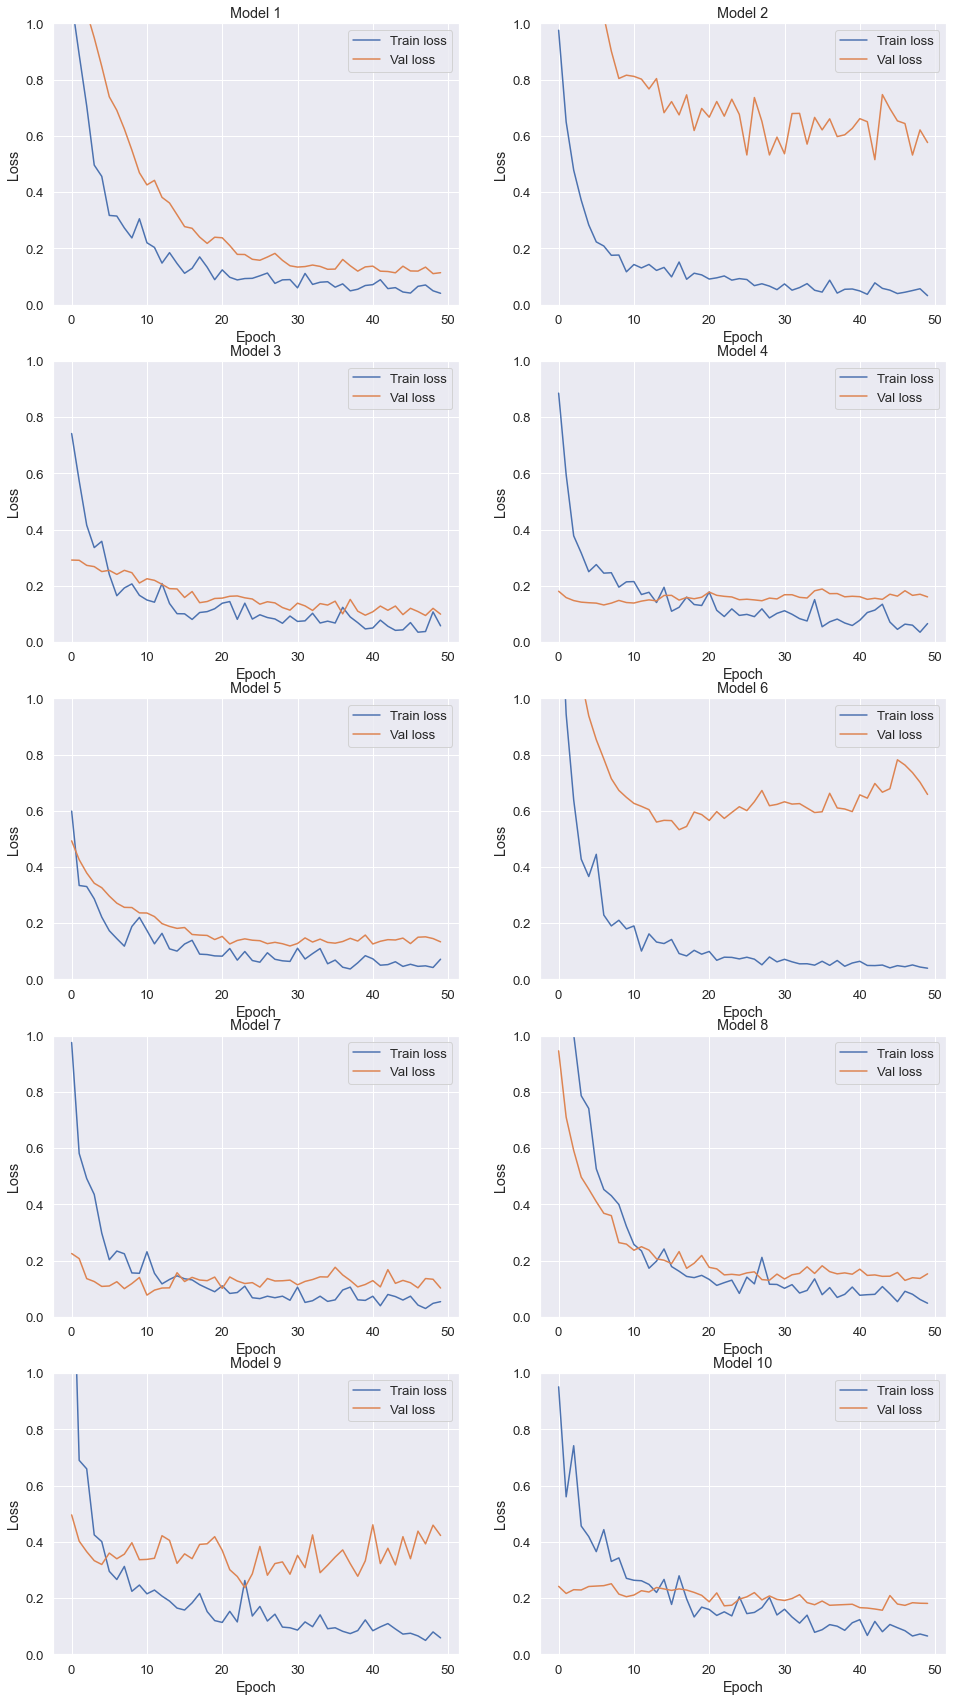

In [116]:
plot_history(models)

In [117]:
mean_mse = get_mean_mse(models)
mean_mse

0.26015672013163565

In [123]:
full_model = build_model(train_data.shape[1])
history = full_model.fit(train_data, train_labels,
                         epochs=100, shuffle=True)

Train on 107 samples
Epoch 1/100
107/107 [==============================] - 1s 5ms/sample - loss: 1.0752
Epoch 2/100
107/107 [==============================] - 0s 84us/sample - loss: 0.5373
Epoch 3/100
107/107 [==============================] - 0s 112us/sample - loss: 0.5110
Epoch 4/100
107/107 [==============================] - 0s 112us/sample - loss: 0.3980
Epoch 5/100
107/107 [==============================] - 0s 93us/sample - loss: 0.3550
Epoch 6/100
107/107 [==============================] - 0s 121us/sample - loss: 0.3481
Epoch 7/100
107/107 [==============================] - 0s 130us/sample - loss: 0.2496
Epoch 8/100
107/107 [==============================] - 0s 121us/sample - loss: 0.2427
Epoch 9/100
107/107 [==============================] - 0s 84us/sample - loss: 0.1815
Epoch 10/100
107/107 [==============================] - 0s 121us/sample - loss: 0.1827
Epoch 11/100
107/107 [==============================] - 0s 93us/sample - loss: 0.1840
Epoch 12/100
107/107 [===============

In [126]:
def predict(tank_params):
    best_model = get_best_model(models)
    
    tank_params['item_price_gold'] = 0
    
    scaled = gold_scaler.transform(tank_params)[:,:len(tank_params.columns) - 1]
    components = pcaGold.transform(scaled)
    
    pred_full = full_model.predict(components)
    pred_best = best_model.predict(components)
    
    x_full = np.concatenate((scaled[0], pred_full[0]))
    x_best = np.concatenate((scaled[0], pred_best[0]))
    
    return gold_scaler.inverse_transform(x_full)[-1], gold_scaler.inverse_transform(x_best)[-1]

predict(tank_params)

(11211.847735814446, 9531.20289632215)

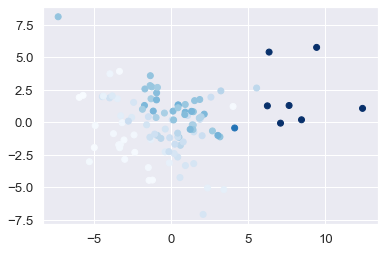

In [109]:
pca = PCA(n_components=2)

X = pca.fit_transform(normed_gold_dataset)

plt.scatter(X[:, 0], X[:, 1], c=normed_gold_dataset[['item_price_gold']].values, cmap='Blues')

plt.show()